In [220]:
#神经网络的继续优化 增加momentum rmsprop 以及adam算法 以点的区分为例

In [239]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import operator
import sklearn
from functools import reduce
import h5py
import sklearn.datasets
import tensorflow as tf

In [276]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/mydata/', one_hot=True)#导入mnist数据集

Extracting /mydata/train-images-idx3-ubyte.gz
Extracting /mydata/train-labels-idx1-ubyte.gz
Extracting /mydata/t10k-images-idx3-ubyte.gz
Extracting /mydata/t10k-labels-idx1-ubyte.gz


In [277]:
#获取原始训练集和标签
train_image_ori = mnist.train.images
train_label_ori = mnist.train.labels

In [278]:
#查看维度
print(train_image_ori.shape)
print(train_label_ori.shape)

(55000, 784)
(55000, 10)


In [279]:
#数据预处理
train_image = train_image_ori.T
train_label = train_label_ori.T

In [280]:
print(train_image_ori.shape)
print(train_label_ori.shape)
print(train_image.shape)
print(train_label.shape)

(55000, 784)
(55000, 10)
(784, 55000)
(10, 55000)


In [281]:
#查看数据极值
print(np.max(train_image))
print(np.min(train_image))

1.0
0.0


In [282]:
#使用两层神经网络，使用relu函数和sigmoid函数，第一层n_h节点
def init_paramters_deep(Layer_dims):
    np.random.seed(3)
    paramters = {}
    V = {}
    S = {}
    for i in range(1,len(Layer_dims)):
        paramters['W'+str(i)] = np.random.randn(Layer_dims[i],Layer_dims[i-1])/np.sqrt(Layer_dims[i-1])#这也是个修改点
        paramters['b'+str(i)] = np.zeros((Layer_dims[i],1))
        V['dW'+str(i)] = np.zeros((Layer_dims[i],Layer_dims[i-1]))
        V['db'+str(i)] = np.zeros((Layer_dims[i],1))
        S['dW'+str(i)] = np.zeros((Layer_dims[i],Layer_dims[i-1]))
        S['db'+str(i)] = np.zeros((Layer_dims[i],1))
    return paramters,V,S

In [283]:
#定义激活函数
def activation(x,activate):
    if(activate=='relu'):
        return (abs(x)+x)/2
    if(activate=='sigmoid'):
        return 1/(1+np.exp(-x))
    if(activate=='softmax'):
        maxnum = np.max(x)
        x = x-maxnum
        t = np.exp(x)
        return t/(np.sum(t,axis=0))

In [284]:
#进行前向传播
def forward(X,paramters,keep_prob):
    cache = {}
    a = X
    cache['A0']=X
    length = len(paramters)//2+1
    for i in range(1,length):
        W = paramters['W'+str(i)]
        b = paramters['b'+str(i)]
        Z = np.dot(W,a)+b
        #cache['mu'+str(i)] = np.mean(Z,axis=1)
        #cache['sigma'+str(i)] = np.std(Z,axis=1)
        #cache['Zn'+str(i)] = (Z-cache['mu'+str(i)])/cache['sigma'+str(i)]
        #cache['Znn']
        cache['Z'+str(i)] = Z
        if(i!=length-1):
            a = activation(Z,'relu')
            D = np.random.rand(a.shape[0],a.shape[1])
            D = (D<keep_prob).astype(int) 
            cache['D'+str(i)] = D
            a = a*D
            a =a/keep_prob
        else:
            a = activation(Z,'softmax')
        cache['A'+str(i)] = a
    return cache

In [285]:
def forward_without_prob(X,paramters):
    cache = {}
    a = X
    cache['A0']=X
    length = len(paramters)//2+1
    for i in range(1,length):
        W = paramters['W'+str(i)]
        b = paramters['b'+str(i)]
        Z = np.dot(W,a)+b
        cache['Z'+str(i)] = Z
        if(i!=length-1):
            a = activation(Z,'relu')
        else:
            a = activation(Z,'softmax')
        cache['A'+str(i)] = a
    return cache    

In [286]:
#计算损失函数
def computeCost(A,Y,lamdb,Layer_dims,parameters):
    m = Y.shape[1]
    reg = 0
    #cost = (-1/A.shape[1])*np.nansum((Y*np.log(A))+(1-Y)*np.log(1-A))
    cost = (-1/A.shape[1])*np.nansum(Y*np.log(A))
    if(lamdb==0):
        return cost
    else:
        for i in range(1,len(Layer_dims)):
            reg +=np.sum(np.square(parameters['W'+str(i)]))
    return cost+(lamdb/(2*m))*reg

In [287]:
#进行反向传播计算
def backward(X,caches,Y,paramters,lamdb,keep_prob):
    m = X.shape[1]
    length = len(paramters)//2+1
    grads={}
    dZ = caches['A'+str(length-1)]-Y
    for i in reversed(range(1,length)):
        w = paramters['W'+str(i)]
        a_prev = caches['A'+str(i-1)]
        dw = (1./m)*np.dot(dZ,a_prev.T)+(lamdb/m)*w
        db = (1./m)*np.sum(dZ,axis=1,keepdims=True)
        if i-1!=0:
            d = caches['D'+str(i-1)]
            da_prev = np.dot(w.T,dZ)*d
            da_prev/=keep_prob
        else:
            da_prev = np.dot(w.T,dZ)
        dZ = np.multiply(da_prev, np.int64(a_prev > 0))#这一步，关键所在
        grads['dW'+str(i)] = dw
        grads['db'+str(i)] = db
    return grads

In [288]:
def backward_without_prob(X,caches,Y,paramters,lamdb):
    m = X.shape[1]
    length = len(paramters)//2+1
    grads={}
    dZ = caches['A'+str(length-1)]-Y
    for i in reversed(range(1,length)):
        w = paramters['W'+str(i)]
        a_prev = caches['A'+str(i-1)]
        dw = (1./m)*np.dot(dZ,a_prev.T)+(lamdb/m)*w
        db = (1./m)*np.sum(dZ,axis=1,keepdims=True)
        da_prev = np.dot(w.T,dZ)
        dZ = np.multiply(da_prev, np.int64(a_prev > 0))#这一步，关键所在
        grads['dW'+str(i)] = dw
        grads['db'+str(i)] = db
    return grads

In [289]:
def update_paramters(paramters,grads,learning_rate):
    length = len(paramters)//2+1
    for i in range(1,length):
        paramters['W'+str(i)] = paramters['W'+str(i)]-learning_rate*grads['dW'+str(i)]
        paramters['b'+str(i)] = paramters['b'+str(i)]-learning_rate*grads['db'+str(i)]
    return paramters

In [290]:
def update_paramters_with_momentum(paramters,grads,learning_rate,V,beta):
    length = len(paramters)//2+1
    for i in range(1,length):
        V['dW'+str(i)] = V['dW'+str(i)]*beta+(1-beta)*grads['dW'+str(i)]
        V['db'+str(i)] = V['db'+str(i)]*beta+(1-beta)*grads['db'+str(i)]
        paramters['W'+str(i)] = paramters['W'+str(i)]-learning_rate*V['dW'+str(i)]
        paramters['b'+str(i)] = paramters['b'+str(i)]-learning_rate*V['db'+str(i)]
    return paramters,V

In [291]:
def update_paramters_with_RMSPorp(paramters,grads,learning_rate,S,beta):
    length = len(paramters)//2+1
    for i in range(1,length):
        S['dW'+str(i)] = S['dW'+str(i)]*beta+(1-beta)*(grads['dW'+str(i)]**2)
        S['db'+str(i)] = S['db'+str(i)]*beta+(1-beta)*(grads['db'+str(i)]**2)
        paramters['W'+str(i)] = paramters['W'+str(i)]-(learning_rate*(grads['dW'+str(i)]))/((np.sqrt(S['dW'+str(i)])+1e-8))
        paramters['b'+str(i)] = paramters['b'+str(i)]-(learning_rate*grads['db'+str(i)])/((np.sqrt(S['db'+str(i)])+1e-8))
    return paramters,S

In [292]:
def update_paramters_with_Adam(paramters,grads,learning_rate,V,S,beta1,beta2,t):
    length = len(paramters)//2+1
    v_corrected=  {}
    s_corrected = {}
    for i in range(1,length):
        V['dW'+str(i)] = V['dW'+str(i)]*beta1+(1-beta1)*grads['dW'+str(i)]
        V['db'+str(i)] = V['db'+str(i)]*beta1+(1-beta1)*grads['db'+str(i)]
        v_corrected["dW" + str(i)] = V["dW" + str(i)]/(1-beta1**t)
        v_corrected["db" + str(i)] = V["db" + str(i)]/(1-beta1**t)
        S["dW" + str(i)] = S["dW" + str(i)]*beta2+(1-beta2)*(grads['dW'+str(i)]**2)
        S["db" + str(i)] = S["db" + str(i)]*beta2+(1-beta2)*(grads['db'+str(i)]**2)
        s_corrected["dW" + str(i)] = S["dW" + str(i)]/(1-beta2**t)
        s_corrected["db" + str(i)] = S["db" + str(i)]/(1-beta2**t)
        paramters["W" + str(i)] = paramters["W" + str(i)]-learning_rate*(v_corrected["dW" + str(i)]/(np.sqrt(s_corrected["dW" + str(i)])+1e-8))
        paramters["b" + str(i)] = paramters["b" + str(i)]-learning_rate*(v_corrected["db" + str(i)]/(np.sqrt(s_corrected["db" + str(i)])+1e-8))
    return paramters,V,S

In [293]:
def create_batch(X,Y,batch_size):
    total_num = X.shape[1]
    batch_num = 0
    mini_batchs = []
    permutation = list(np.random.permutation(total_num))
    shuffle_x = X[:,permutation]
    shuffle_y = Y[:,permutation]
    if total_num%batch_size==0:
        batch_num = (int)(total_num/batch_size)
        for i in range(batch_num):
            mini_batch = (shuffle_x[:,i*batch_size:(i+1)*batch_size],shuffle_y[:,i*batch_size:(i+1)*batch_size])
            mini_batchs.append(mini_batch)
    else:
        batch_num = (int)(total_num/batch_size)+1
        for i in range(batch_num-1):
            mini_batch = (shuffle_x[:,i*batch_size:(i+1)*batch_size],shuffle_y[:,i*batch_size:(i+1)*batch_size])
            mini_batchs.append(mini_batch)
        left= (shuffle_x[:,(batch_num-1)*batch_size:],shuffle_y[:,(batch_num-1)*batch_size:])
        mini_batchs.append(left)
    #return np.array(mini_batchs)
    return mini_batchs

In [302]:
#建立浅层神经网络模型
def nn_model(X,Y,learning_rate,epochs,layer_dims,lamdb,keep_prob,batch_size,optimizer=None,beta1=0.9,beta2=0.999):
    losses = []
    paramters,V,S = init_paramters_deep(layer_dims)#完全一致
    length = len(layer_dims)
    mini_batchs = create_batch(X,Y,batch_size)
    t = 0
    for i in range(epochs):
        for mini_batch in mini_batchs:
            mini_X = mini_batch[0]
            mini_Y  = mini_batch[1]
            if(keep_prob==1):
                caches=forward_without_prob(mini_X,paramters)
                grads = backward_without_prob(mini_X,caches,mini_Y,paramters,lamdb)
            else:
                caches = forward(mini_X,paramters,keep_prob)
                grads = backward(mini_Y,caches,Y,paramters,lamdb,keep_prob)
            if optimizer=='momentum':
                paramters,V  = update_paramters_with_momentum(paramters,grads,learning_rate,V,beta1)
            if optimizer==None:
                paramters = update_paramters(paramters,grads,learning_rate)
            if optimizer=='RMSProp':
                paramters,S  = update_paramters_with_RMSPorp(paramters,grads,learning_rate,S,beta2)
            if optimizer=='Adam':
                t =t+1
                paramters,V,S = update_paramters_with_Adam(paramters,grads,learning_rate,V,S,beta1,beta2,t)
        cost = computeCost(caches['A'+str(length-1)],mini_Y,lamdb,layer_dims,paramters)
        losses.append(cost)
        if i%100==0:
            print(cost)
    plt.plot(losses)
    return paramters,losses

In [295]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  n-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    p = np.zeros((1,m), dtype = np.int)
    
    # Forward propagation
    caches = forward(X, parameters,1)
    a3 = caches['A3']
    
    # convert probas to 0/1 predictions
    for i in range(0, a3.shape[1]):
        if a3[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    # print results

    #print ("predictions: " + str(p[0,:]))
    #print ("true labels: " + str(y[0,:]))
    print("Accuracy: "  + str(np.mean((p[0,:] == y[0,:]))))
    
    return p

In [296]:
#计算预测准确率
def accuracy(X,Y,parameters):
    caches = forward(X,parameters,1)
    length = len(parameters)//2+1
    A = caches['A'+str(length-1)]
    idx1 = np.argmax(A,axis=0)
    idx2 = np.argmax(Y,axis=0)
    cmp = (idx1==idx2)
    return np.sum(cmp)/idx1.shape[0]

In [297]:
test_image_ori = mnist.test.images
test_label_ori = mnist.test.labels

In [298]:
test_image = test_image_ori.T
test_label = test_label_ori.T

In [300]:
layer_dims = [train_image.shape[0],20,5,10]

In [301]:
#没训练前的准确率
parameters,v,s = init_paramters_deep(layer_dims)
print(accuracy(train_image,train_label,parameters))

0.11152727272727272


1.8446224818637587
1.6916107793113684
1.5567902933887643
1.451556685843626
1.3735852262947796
1.3296768318703056
1.2982047993182033
1.2753073031113054
1.2624564524542055
1.249215813204178
1.2463928071948394
1.241164391129178
1.2362302685206374
1.2307425445933706
1.2265680056482016
1.222382551572764
1.2183014277296038
1.2131610786977138
1.205758763690155
1.1982524327276942
0.6609090909090909


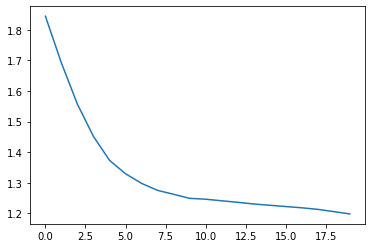

In [270]:
parameters,loss = nn_model(train_image, train_label,0.05,20,layer_dims,0,1,train_X.shape[1])
print(accuracy(train_image,train_label,parameters))
#使用普通梯度下降算法 正确率较低

0.20535320016154124
accuracy in train set 0.9632363636363637
accuracy in test set 0.948


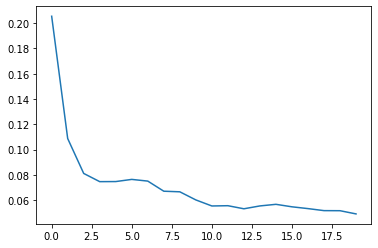

In [303]:
parameters,loss = nn_model(train_image, train_label,0.05,20,layer_dims,0,1,64)
print("accuracy in train set "+str(accuracy(train_image,train_label,parameters)))
print("accuracy in test set "+str(accuracy(test_image,test_label,parameters)))
#使用mini-batch下降算法 正确率提高

1.8808617734465305
1.4066397058164402
1.2086921680674252
1.077419263676783
1.0068933794068324
1.0010658760936635
0.983687777756078
0.9495168683909638
0.9302636894799883
0.9323215636293098
0.9421294130263527
0.954270165913303
0.9232502688962718
0.9174359883637099
0.8978464069028531
0.8946201422848692
0.8806781818151539
0.8896829973368379
0.8828999167170078
0.8841100248199867
accuracy in train set 0.7763818181818182
accuracy in test set 0.7782


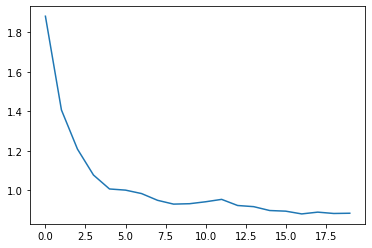

In [273]:
parameters,loss = nn_model(train_image, train_label,0.05,20,layer_dims,0,1,64,optimizer='momentum')
print("accuracy in train set "+str(accuracy(train_image,train_label,parameters)))
print("accuracy in test set "+str(accuracy(test_image,test_label,parameters)))

1.450099441194466
1.1840498706210036
0.9907502792842202
0.8513849208558183
0.7010617004746897
0.626187667940145
0.6104620364167853
0.5945198384573185
0.5818209370509622
0.5799037515052519
0.5812044937204983
0.5961625848715102
0.6076343173029176
0.6132737128083714
0.6199036817633818
0.6271499294802068
0.6242638228503423
0.6284771017609798
0.6195368315820823
0.6165990142861122
accuracy in train set 0.7566909090909091
accuracy in test set 0.7556


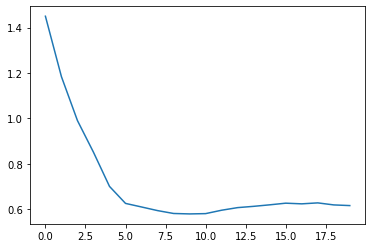

In [274]:
parameters,loss = nn_model(train_image, train_label,0.007,20,layer_dims,0,1,64,optimizer='RMSProp')
print("accuracy in train set "+str(accuracy(train_image,train_label,parameters)))
print("accuracy in test set "+str(accuracy(test_image,test_label,parameters)))

1.9271204691370674
1.7796789454039939
1.5866067503200703
1.4443014713546511
1.3141824385903473
1.2198717279887017
1.1427894829426686
1.0757554759455736
1.0062849814033088
0.9351362329679019
0.8726992491130274
0.8167798642585368
0.7695421279961759
0.7266547542175723
0.6914993455659213
0.6637439623516337
0.6452589436197316
0.6310144847736022
0.6206935967769438
0.6110948455359241
0.5998359787724394
0.5939817044821079
0.5866303721159919
0.5799521738106378
0.5756672328726502
0.5690298965082201
0.5671484146429785
0.5479555584302334
0.5438947651460794
0.5418147383716561
0.5397015754541732
0.538851051362161
0.5365728179045137
0.5361802734799661
0.5353351883314074
0.5413579418185359
0.5390611860562389
0.540279696950103
0.5353696749271549
0.5388181535008971
0.5368380987994437
0.5346024922971709
0.5339094848429633
0.5335981350941803
0.532891546102226
0.5341472207964455
0.5347870875628942
0.532207057223194
0.5348905425360843
0.5319385321118193
0.5322538806840189
0.5317200084940509
0.53053321590010

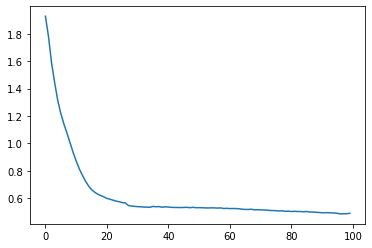

In [275]:
parameters,loss = nn_model(train_image, train_label,0.0007,100,layer_dims,0,1,64,optimizer='Adam')
print("accuracy in train set "+str(accuracy(train_image,train_label,parameters)))
print("accuracy in test set "+str(accuracy(test_image,test_label,parameters)))